# Auction AI

**Overview**: In this practical application, we will create a complete AI / ML for predicting prices for luxury good auctions. We will do a complate exploratory data analysis of auction data, clean the data, and create some initial models and score them.

### Getting Started

Our dataset comes from Kaggle repository [link](https://www.kaggle.com/datasets/onlineauctions/online-auctions-dataset).  There are two datasets, both dealing with auction data.

Second the `luxury_action.csv` which is a collection of action results of luxury good auctions.

The goal is to build a model to answer the question:

`What are the important (salient) features that determine the best price of goods at auction`

Stated differently we want to discover:

`What are the key factors that help increase selling prices of luxury auction items?`

### Understanding the Data

First step is to understand the datasets by loading and doing some initial data engineering, removing nulls, and simplifying column names. Use pandas to read in the dataset `luxury_auction.csv` and assign to a meaningful variable name.

In [2]:
import pandas as pd

In [12]:
luxury_df = pd.read_csv('data/luxury_auction.csv', sep = ',')

In [13]:
luxury_df.head()

,auctionid,bid,bidtime,bidder,bidderrate,openbid,price,item,auction_type
0,1638893549,175.0,2.230949,schadenfreud,0.0,99.0,177.5,Cartier wristwatch,3 day auction
1,1638893549,100.0,2.600116,chuik,0.0,99.0,177.5,Cartier wristwatch,3 day auction
2,1638893549,120.0,2.600810,kiwisstuff,2.0,99.0,177.5,Cartier wristwatch,3 day auction
3,1638893549,150.0,2.601076,kiwisstuff,2.0,99.0,177.5,Cartier wristwatch,3 day auction
4,1638893549,177.5,2.909826,eli.flint@flightsafety.co,4.0,99.0,177.5,Cartier wristwatch,3 day auction


In [14]:
luxury_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10681 entries, 0 to 10680
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   auctionid     10681 non-null  int64  
 1   bid           10681 non-null  float64
 2   bidtime       10681 non-null  float64
 3   bidder        10665 non-null  object 
 4   bidderrate    10670 non-null  float64
 5   openbid       10681 non-null  float64
 6   price         10681 non-null  float64
 7   item          10681 non-null  object 
 8   auction_type  10681 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 751.1+ KB


### Understanding the Features

Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.

Input variables:

* `auctionid`    (int64) - unique identifier of an auction
* `bid`          (float64) - the proxy bid placed by a bidder
* `bidtime`      (float64) - the time in days that the bid was placed, from the start of the auction
* `bidder`       (object) - eBay username of the bidder
* `bidderrate`   (float64) - eBay feedback rating of the bidder
* `openbid`      (float64) - the opening bid set by the seller
* `item`         (object) - a description of the item being auctioned
* `auction_type` (object) - the type of auction: 3 days, ...

Output variable (desired target):

* `price`        (float64) - the closing price that the item sold for (equivalent to the second highest bid + an increment)


### Basic data cleaning

Do basic initial data cleaning, column rename, and removing nulls.

In [19]:
# Make a copy of the dataframe as the one we will use in analysis so we can also have a backup
df = luxury_df.copy()

# Let's change column names to be consistent and pythonic: 
# auctionid => auction_id, bidtime => bid_time, bidderrate => bidder_rate, and openbid => open_bid
new_column_names = {
    'auctionid': 'auction_id', 
    'bidtime': 'bid_time', 
    'bidderrate': 'bidder_rate', 
    'openbid': 'open_bid'
}

df.rename(columns=new_column_names, inplace=True)
df.head()

,auction_id,bid,bid_time,bidder,bidder_rate,open_bid,price,item,auction_type
0,1638893549,175.0,2.230949,schadenfreud,0.0,99.0,177.5,Cartier wristwatch,3 day auction
1,1638893549,100.0,2.600116,chuik,0.0,99.0,177.5,Cartier wristwatch,3 day auction
2,1638893549,120.0,2.600810,kiwisstuff,2.0,99.0,177.5,Cartier wristwatch,3 day auction
3,1638893549,150.0,2.601076,kiwisstuff,2.0,99.0,177.5,Cartier wristwatch,3 day auction
4,1638893549,177.5,2.909826,eli.flint@flightsafety.co,4.0,99.0,177.5,Cartier wristwatch,3 day auction


In [20]:
# Check for nulls
df.isna().sum()

auction_id       0
bid              0
bid_time         0
bidder          16
bidder_rate     11
open_bid         0
price            0
item             0
auction_type     0
dtype: int64

In [21]:
# Set nulls bidders to 'unknown' and bidder_rate to '0'
df['bidder'].fillna('unknown', inplace = True)
df['bidder_rate'].fillna(0.0, inplace = True)

df.isna().sum()

auction_id      0
bid             0
bid_time        0
bidder          0
bidder_rate     0
open_bid        0
price           0
item            0
auction_type    0
dtype: int64

In [23]:
# Print basic statistics on numerical data
df.describe()

,auction_id,bid,bid_time,bidder_rate,open_bid,price
count,1.068100e+04,10681.000000,10681.000000,10681.000000,10681.000000,10681.000000
mean,4.136148e+09,207.586109,3.979628,31.903848,52.246256,335.043589
std,2.489918e+09,323.037396,2.353386,120.536308,168.453245,433.566009
min,1.638844e+09,0.010000,0.000567,-4.000000,0.010000,26.000000
25%,3.015329e+09,72.000000,1.949931,1.000000,1.000000,186.510000
50%,3.020526e+09,140.000000,4.140833,5.000000,4.990000,228.490000
75%,8.212136e+09,210.000000,6.448060,21.000000,50.000000,255.000000
max,8.215611e+09,5400.000000,6.999990,3140.000000,5000.000000,5400.000000


In [24]:
# Do a frequency graph (histogram) of the three categorical data: bidder, item, and auction_type

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

pd.option_context('mode.use_inf_as_na', True);

In [36]:
# bidder: since we don't care to know the actually bidder let's encode bidder as numerical integers
label_encoder = LabelEncoder()
df['bidder'] = label_encoder.fit_transform(df['bidder'])

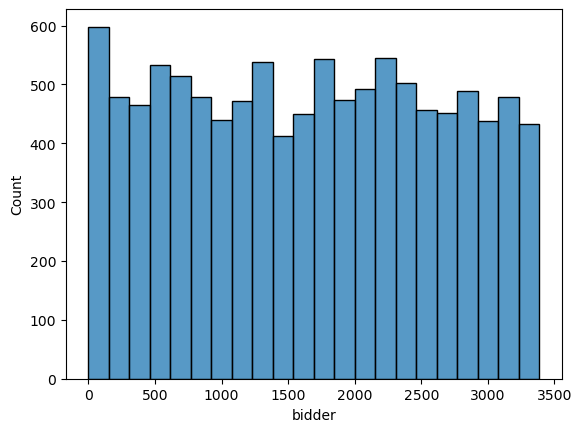

In [37]:
# bidder
sns.histplot(df, x='bidder')
plt.show()

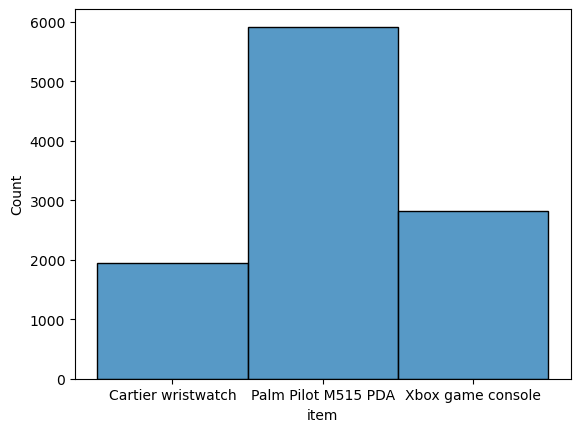

In [30]:
# item
sns.histplot(df, x='item')
plt.show()

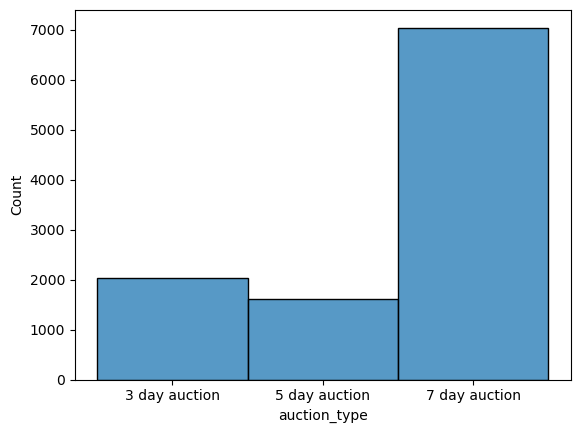

In [31]:
# auction_type
sns.histplot(df, x='auction_type')
plt.show()

In [38]:
# Encode the other two categorical data since this will allow easier modeling
df['item'] = label_encoder.fit_transform(df['item'])
df['auction_type'] = label_encoder.fit_transform(df['auction_type'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10681 entries, 0 to 10680
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   auction_id    10681 non-null  int64  
 1   bid           10681 non-null  float64
 2   bid_time      10681 non-null  float64
 3   bidder        10681 non-null  int64  
 4   bidder_rate   10681 non-null  float64
 5   open_bid      10681 non-null  float64
 6   price         10681 non-null  float64
 7   item          10681 non-null  int64  
 8   auction_type  10681 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 751.1 KB


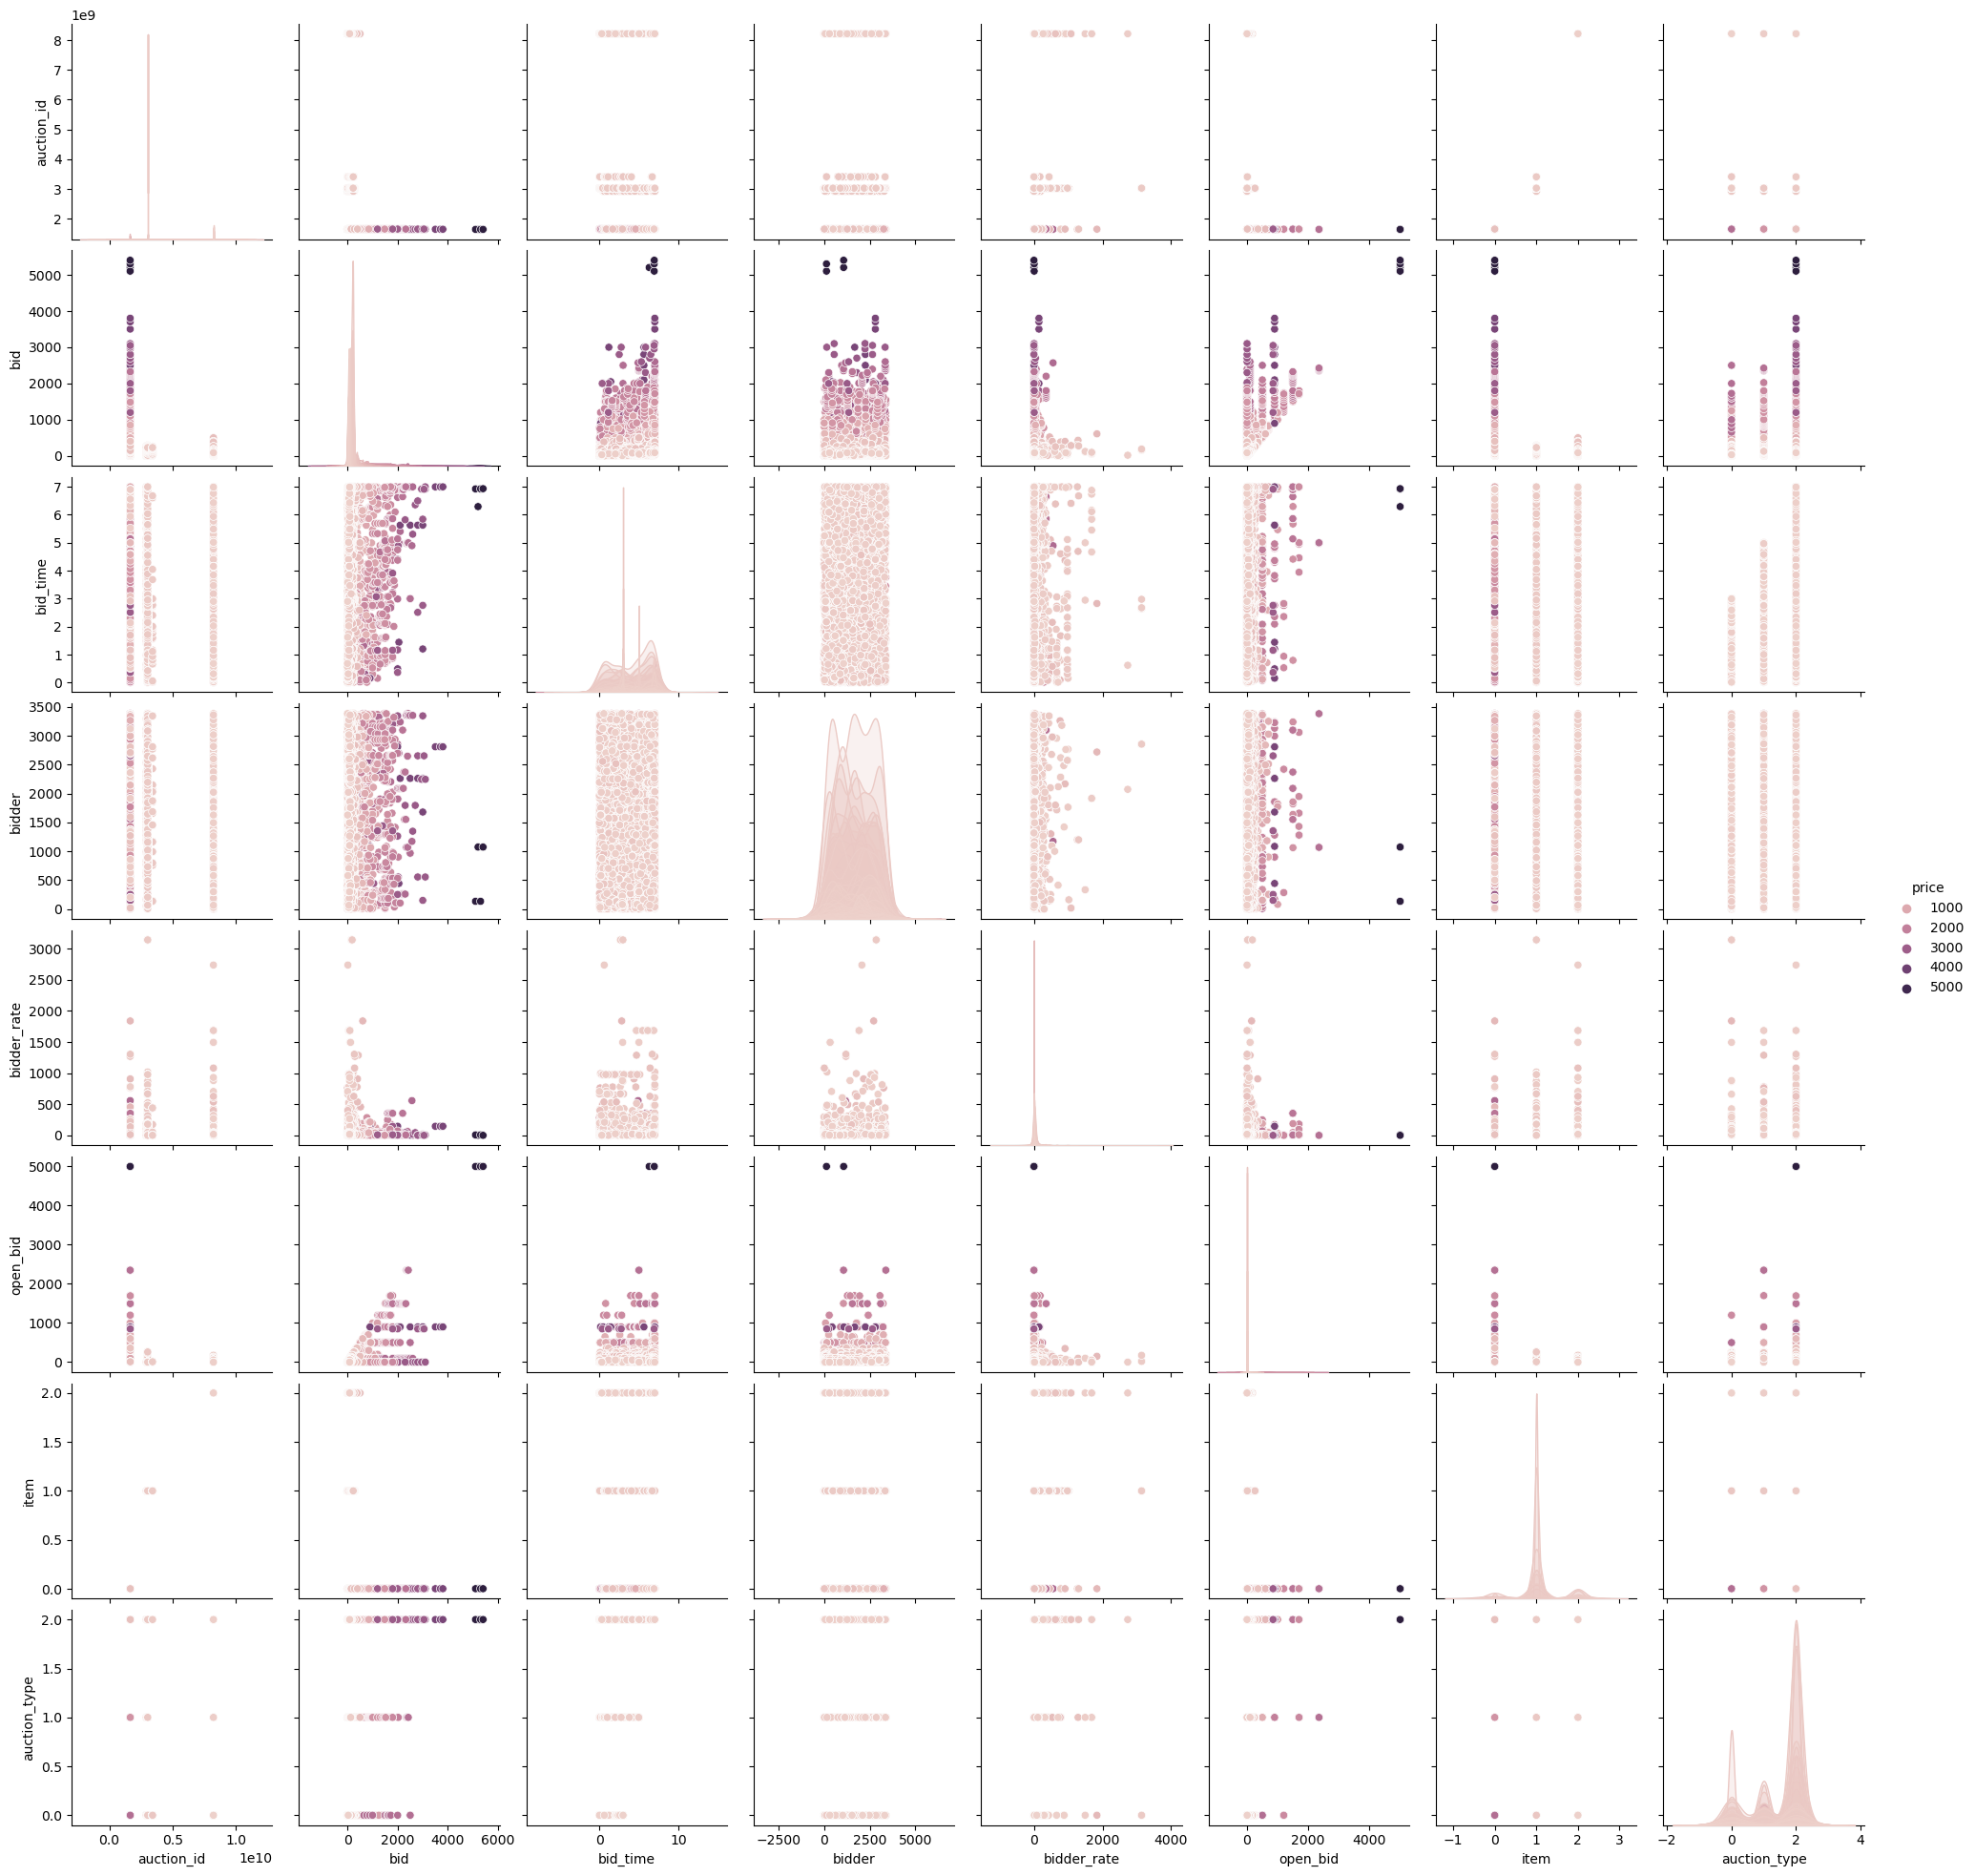

In [39]:
# Create a pairplot between all featrues to identify any obiouvs clusters, coloring with price
sns.pairplot(df, hue='price')

### Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

### Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

### Train/Test Split

With your data prepared, split it into a train and test set.

### A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

### A Simple Model

Use Logistic Regression to build a basic model on your data.  

### Score the Model

What is the accuracy of your model?

### Advanced Models

Use Decision Tree, KNN, KMeans, and  to build a basic model on your data.  

### Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

### Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Questions